In [1]:
from sklearn.metrics import roc_curve, auc

from predictor.models import TFAkiBase, TFAkiLstm, TFAkiGpt2
from predictor.utils import convert_preds

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
test_matrix = np.load('../dataset/matrix_testing.npy').astype(np.float32)
test_x = test_matrix[:, :, :-1]
test_y = test_matrix[:, :, -1:]

In [3]:
model = TFAkiBase()
model.load_weights('../saved_models/base_e1000/base').expect_partial()

y_hat = model(test_x)
y, y_hat = convert_preds(test_x, test_y, y_hat)
base_fpr, base_tpr, _ = roc_curve(y, y_hat)
base_auc = auc(base_fpr, base_tpr)

In [4]:
model = TFAkiLstm(timesteps=8, n_features=16)
model.load_weights('../saved_models/lstm_e500/lstm').expect_partial()

y_hat, _ = model(test_x)
y, y_hat = convert_preds(test_x, test_y, y_hat)
lstm_fpr, lstm_tpr, _ = roc_curve(y, y_hat)
lstm_auc = auc(lstm_fpr, lstm_tpr)

In [5]:
model = TFAkiGpt2(n_heads=2, timesteps=8, n_features=16, n_layers=32)
model.load_weights('../saved_models/gpt2_e1000/gpt2').expect_partial()

y_hat, _ = model(test_x)
y, y_hat = convert_preds(test_x, test_y, y_hat)
gpt2_fpr, gpt2_tpr, _ = roc_curve(y, y_hat)
gpt2_auc = auc(gpt2_fpr, gpt2_tpr)

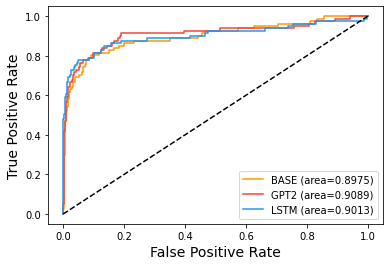

In [6]:
plt.plot(base_fpr, base_tpr, label=f'BASE (area={base_auc:.4f})', color='#FF9800')
plt.plot(gpt2_fpr, gpt2_tpr, label=f'GPT2 (area={gpt2_auc:.4f})', color='#F44336')
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (area={lstm_auc:.4f})', color='#2196F3')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
plt.show()

In [7]:
# get feature column names
import pandas as pd

df = pd.read_csv('../dataset/events_complete.csv')
exclude = ['stay_day', 'stay_id', 'subject_id', 'hadm_id', 'aki']
columns = [c for c in df.columns if c not in exclude]

assert len(columns) == 16

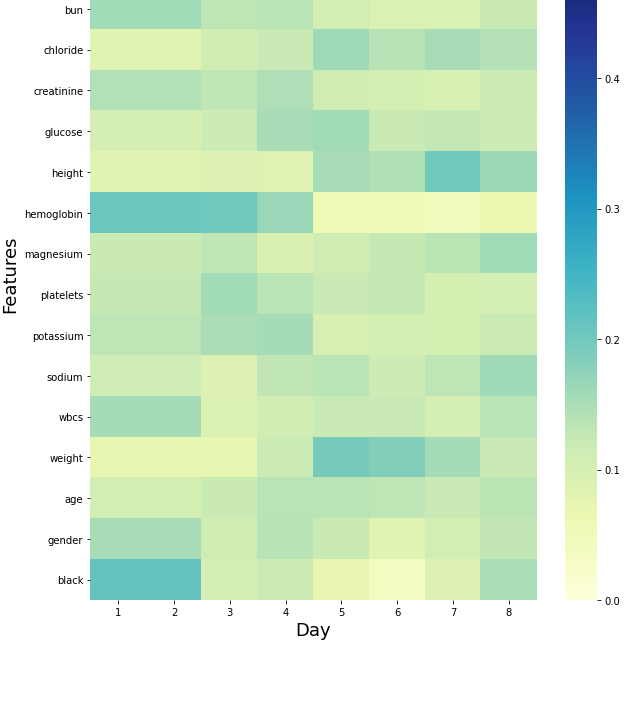

In [8]:
# generate sample heatmap from LSTM
model = TFAkiLstm(timesteps=8, n_features=16)
model.load_weights('../saved_models/lstm_e500/lstm').expect_partial()
_, w = model(test_x[1:, :, :])
w = w[0].numpy().T

assert np.max(w) <= 0.5
plt.figure(figsize=(10,12))
sns.heatmap(w, xticklabels=np.arange(8) + 1, yticklabels=columns, vmin=0, vmax=0.5, linewidths=0, cmap='YlGnBu')
plt.ylabel('Features', fontsize=18)
plt.xlabel('Day', fontsize=18)
plt.show()

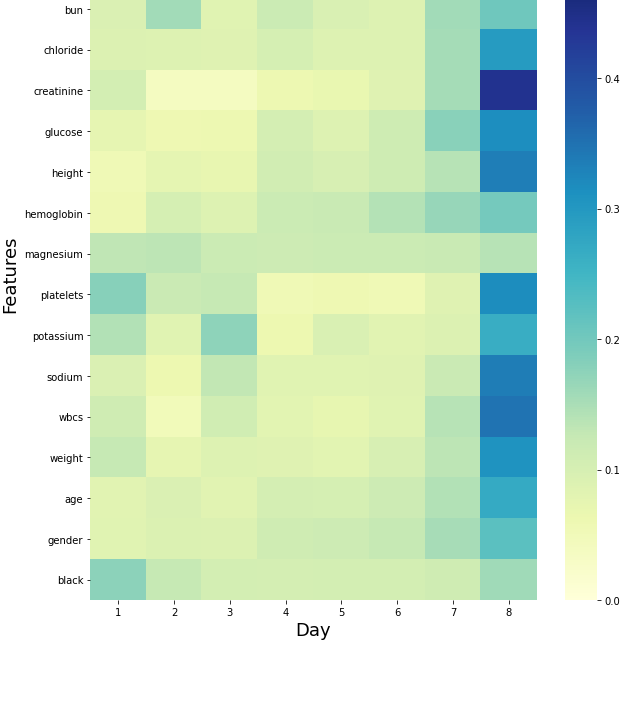

In [9]:
# generate sample heatmap from GPT2
model = TFAkiGpt2(n_heads=2, timesteps=8, n_features=16, n_layers=32)
model.load_weights('../saved_models/gpt2_e1000/gpt2').expect_partial()
_, w = model(test_x[1:, :, :])
w = w[0].numpy().T

assert np.max(w) <= 5
plt.figure(figsize=(10,12))
sns.heatmap(w, xticklabels=np.arange(8) + 1, yticklabels=columns, vmin=0, vmax=0.5, linewidths=0, cmap='YlGnBu')
plt.ylabel('Features', fontsize=18)
plt.xlabel('Day', fontsize=18)
plt.show()